# Example of the MR process

This notebook is used for the exploration of the processing steps on the MR scans

In [2]:
import os.path

import nibabel as nib
from nibabel import processing
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from scipy.ndimage import binary_closing, gaussian_filter
from skimage.morphology import ball
from mpl_toolkits.axes_grid1 import ImageGrid



ModuleNotFoundError: No module named 'skimage'

In [ ]:

# TODO: Replace path with relative paths
freesurfer_root = "/media/valerio/Elements/OASIS3_DATASET/OASIS3_MRI_FREESURFER/"
mri_root = "/media/valerio/Elements/OASIS3_DATASET/OASIS3_MRI_SESSIONS/"

health_subject = "OAS30003_MR_d1631"
ad_subject = "OAS30031_MR_d0427"

health_mr_path = join(mri_root, health_subject,"anat3/sub-OAS30003_ses-d1631_run-01_T1w.nii.gz")
health_mask_path = join(freesurfer_root, health_subject, "mri/brain.mgz")

ad_mr_path = join(mri_root, ad_subject, "anat2/sub-OAS30031_ses-d0427_run-01_T1w.nii.gz")
ad_mask_path = join(freesurfer_root, ad_subject, "mri/brainmask.mgz")


In [ ]:

def load_and_conform(path):
    mr = nib.load(path)
    print("Loaded file", os.path.basename(path))
    print("Size\t", mr.header.get_data_shape())
    print("Res.\t", mr.header.get_zooms())
    print("Orient.\t", ''.join(nib.aff2axcodes(mr.affine)))

    print("Conform to LPS and res 1.0")
    mr = processing.conform(mr, voxel_size=(1,1,1), orientation='LPS')
    print("Conformed MR values")
    print("Size\t", mr.header.get_data_shape())
    print("Res.\t", mr.header.get_zooms())
    print("Orient.\t", ''.join(nib.aff2axcodes(mr.affine)))
    return mr.get_fdata()

In [ ]:
health_mr=load_and_conform(health_mr_path)
health_mask = load_and_conform(health_mask_path)

Loaded file sub-OAS30003_ses-d1631_run-01_T1w.nii.gz
Size	 (176, 256, 256)
Res.	 (0.99999976, 1.0, 1.0)
Orient.	 RAS
Conform to LPS and res 1.0
Conformed MR values
Size	 (256, 256, 256)
Res.	 (1.0, 1.0, 1.0)
Orient.	 LPS
Loaded file brain.mgz
Size	 (256, 256, 256)
Res.	 (1.0, 1.0, 1.0)
Orient.	 LIA
Conform to LPS and res 1.0
Conformed MR values
Size	 (256, 256, 256)
Res.	 (1.0, 1.0, 1.0)
Orient.	 LPS


In [ ]:
ad_mr = load_and_conform(ad_mr_path)
ad_mask = load_and_conform(ad_mask_path)

Loaded file sub-OAS30031_ses-d0427_run-01_T1w.nii.gz
Size	 (176, 256, 256)
Res.	 (1.0, 1.0, 1.0)
Orient.	 RAS
Conform to LPS and res 1.0
Conformed MR values
Size	 (256, 256, 256)
Res.	 (1.0, 1.0, 1.0)
Orient.	 LPS
Loaded file brainmask.mgz
Size	 (256, 256, 256)
Res.	 (1.0, 1.0, 1.0)
Orient.	 LIA
Conform to LPS and res 1.0
Conformed MR values
Size	 (256, 256, 256)
Res.	 (1.0, 1.0, 1.0)
Orient.	 LPS


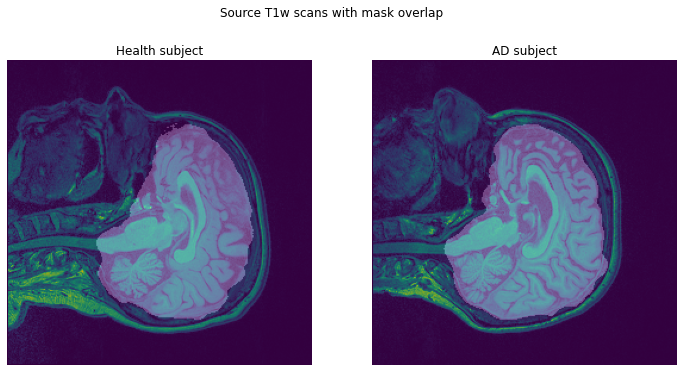

In [ ]:

img, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
mask = ball(2)
slice = 125
img.suptitle("Source T1w scans with mask overlap")
ax1.imshow(health_mr[slice,...] )
ax1.imshow(binary_closing(np.array(health_mask>0))[slice,...], cmap='gray', alpha=0.25)
ax1.set_title("Health subject")
ax1.axis('off')

ax2.imshow(ad_mr[slice,...])
ax2.imshow(binary_closing(np.array(ad_mask>0))[slice,...], cmap='gray', alpha=0.25)
ax2.set_title("AD subject")
ax2.axis('off')
img.savefig("../reports/figures/mr_example_with_mask.png", dpi=300, bbox_inches="tight", transparent=True)

In [ ]:
health_roi = health_mr*binary_closing(np.array(health_mask>0))
ad_roi = ad_mr*binary_closing(np.array(ad_mask>0))

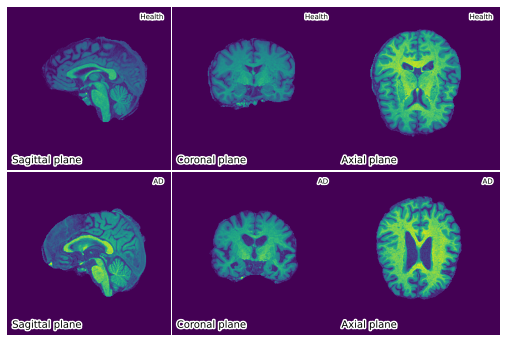

In [ ]:


def add_inner_title(ax, title, loc, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    prop = dict(path_effects=[withStroke(foreground='w', linewidth=3)],
                size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=prop,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    return at

def add_inner_label(ax, title, loc, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    prop = dict(path_effects=[withStroke(foreground='w', linewidth=3)],
                size=7)
    at = AnchoredText(title, loc=loc, prop=prop,
                      pad=0., borderpad=1,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    return at
    


In [ ]:
fig = plt.figure(figsize=(30,20))
slices = np.array(health_roi.shape)//2
HS = [np.rot90(health_roi[slices[0],...]), np.rot90(health_roi[:,slices[1],...]), np.rot90(health_roi[...,slices[2]+20])]
AS = [np.rot90(ad_roi[slices[1],...]), np.rot90(ad_roi[:,slices[1],...]), np.rot90(ad_roi[...,slices[2]+20])]
grid = ImageGrid(fig, 231,nrows_ncols=(2,3),
label_mode="1",
           share_all=True,)

for i, (ax, z) in enumerate(zip(grid, HS+AS)):
    im = ax.imshow(z)
    ax.axis('off')
for ax, im_title in zip(grid, ["Sagittal plane", "Coronal plane", "Axial plane"]*2):
    t = add_inner_title(ax, im_title, loc='lower left')
    t.patch.set_alpha(0.5)
for ax, im_title in zip(grid, ["Health"]*3+["AD"]*3):
    t = add_inner_label(ax, im_title, loc='upper right')
    t.patch.set_alpha(0.2)

fig.savefig("../reports/figures/planar_roi.png", dpi=300, bbox_inches="tight", transparent=True)

NameError: name 'plt' is not defined

The final size of the MR scan is 160x200x168: such measure is roughly equals to the maximum size of the brains in the dataset along each dimension.